# <span style="color:blue">Explainable AI in Natural Language Processing - GRU Training Notebook</span>

## GRU Keras Implementation & Training



Author: Amir Mozahebi <br>
Thesis: Evaluating Sequence Learning Models for Identifying Hate Speech using Explainable AI

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.utils import plot_model
import keras_tuner
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import os, shutil
from keras_tqdm import TQDMNotebookCallback
from keras_tqdm import TQDMCallback
import gc

In [2]:
%store -r sequenceLength
%store -r vocabSize
%store -r paddedTrainSequences
%store -r trainLabels
%store -r paddedTestSequences
%store -r testLabels
%store -r tokenizer

In [3]:
print("Sequence Length: " + str(sequenceLength))
print("Vocab Size: " + str(vocabSize))
print(trainLabels[:5])

Sequence Length: 25
Vocab Size: 28829
23943    1
15123    1
4213     2
18820    1
6261     2
Name: label, dtype: int64


In [4]:
len(paddedTestSequences)

10796

In [5]:
trainLabels = tf.keras.utils.to_categorical(trainLabels, num_classes=3)
testLabels_backup = testLabels
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=3)

In [6]:
trainLabels[0]

array([0., 1., 0.], dtype=float32)

In [7]:
#Define function to plot the history of the model training (accuracy + loss)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

In [8]:
def plotConfusionMatrix(cm):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    ax = sns.heatmap(cm, annot=labels, fmt="",cmap='Blues')

    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])
    ax.yaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## GRU Model Tuning - Using Keras Tuner to optimize hyperparameters

In [9]:
# Callback to use garbage collector after each epoch to improve memory usage
class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [10]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
        model.add(layers.GRU(units=hp.Int("units", min_value=32, max_value=512, step=16)))
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Float("rate", min_value=0.1, max_value=0.5)))
        model.add(layers.Dense(3,activation="sigmoid"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
            loss='binary_crossentropy',
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [11]:
# Define model hyperparameters before tuning
def buildModel(hp):
    model = keras.models.Sequential()
    model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
    model.add(layers.GRU(units=hp.Int("units", min_value=32, max_value=512, step= 16)))
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float("rate", min_value=0.1, max_value=0.5)))
    model.add(layers.Dense(3,activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
    return model

In [12]:
# Method to delete files in log directory
def cleanLogs(path):
    folder = path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [13]:
def tuneModels(epoch_min, epoch_max, step, X_train, X_label, Y_train, Y_label, num_trials):
    
    tuners = []
    best_model_by_epoch = []
    counter=0
    
    for i in range(epoch_min, epoch_max, step):
        counter += 1
        logPath = "training_logs/gru_logs/tb_logs_gru_tuner_" + str(counter)
        cleanLogs(logPath)
        tuner = keras_tuner.BayesianOptimization(
        MyHyperModel(),
        objective='val_accuracy',
        max_trials=num_trials,
        overwrite = True,
        directory='../tuner_dir/gru_tuner_' + str(counter))
        buildModel(keras_tuner.HyperParameters())
        tuner.search(X_train, X_label, epochs=i, validation_data=(paddedTestSequences, testLabels),
        callbacks=[keras.callbacks.TensorBoard(logPath)])
        tuners.append(tuner)
        
    for tuner in tuners:
        model = tuner.get_best_models(num_models=1)
        best_model_by_epoch.append(model[0])
            
    return tuners, best_model_by_epoch

In [14]:
#tuners, best_models = tuneModels(10,31,10,paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5)

In [15]:
def tuneModelByEpoch(epochs, X_train, X_label, Y_train, Y_label, num_trials, logPathCounter):
     
    logPath = "training_logs/gru_logs/tb_logs_gru_tuner_" + str(logPathCounter)
    cleanLogs(logPath)
      
    tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=num_trials,
    overwrite = True,
    directory='../tuner_dir/gru_tuner_' + str(logPathCounter))
    buildModel(keras_tuner.HyperParameters())
    
    tuner.search(X_train, X_label, epochs=epochs, validation_data=(paddedTestSequences, testLabels), verbose=0,
    callbacks=[GCCallback(),keras.callbacks.TensorBoard(logPath)])     
  
    best_model_by_epoch = tuner.get_best_models(num_models=1)[0]
           
    return tuner, best_model_by_epoch

### Find best model for 10 epochs of training

In [29]:
tuner_1, best_model_1 = tuneModelByEpoch(10, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 1)

Metal device set to: Apple M1 Pro


2022-11-16 13:57:30.574396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 13:57:30.574504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-16 13:57:30.946659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-16 13:57:31.334811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 13:57:31.457559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 13:57:31.604749: I tensorflow/core/grappler/o

2022-11-16 14:01:11.208738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:01:11.255599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:03:37.061948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:03:37.187380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:03:37.331132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:04:02.489457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:04:02.536241: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


In [30]:
tuner_1.results_summary()

Results summary
Results in ../tuner_dir/gru_tuner_1/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 384
units: 352
dropout: True
lr: 0.0003774139757787652
batch_size: 128
rate: 0.1
Score: 0.841052234172821
Trial summary
Hyperparameters:
output_dim: 480
units: 128
dropout: False
lr: 0.00031796624134158076
batch_size: 64
rate: 0.14671375801514688
Score: 0.8407743573188782
Trial summary
Hyperparameters:
output_dim: 64
units: 128
dropout: False
lr: 0.0012541399828679741
batch_size: 32
Score: 0.8304001688957214
Trial summary
Hyperparameters:
output_dim: 96
units: 448
dropout: False
lr: 0.0014597926340128918
batch_size: 32
rate: 0.29532464121992974
Score: 0.8226194977760315
Trial summary
Hyperparameters:
output_dim: 448
units: 224
dropout: True
lr: 0.005212522608558277
batch_size: 32
rate: 0.2671003446699072
Score: 0.75


In [34]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 384)           11070336  
                                                                 
 gru (GRU)                   (None, 352)               779328    
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 3)                 1059      
                                                                 
Total params: 11,850,723
Trainable params: 11,850,723
Non-trainable params: 0
_________________________________________________________________


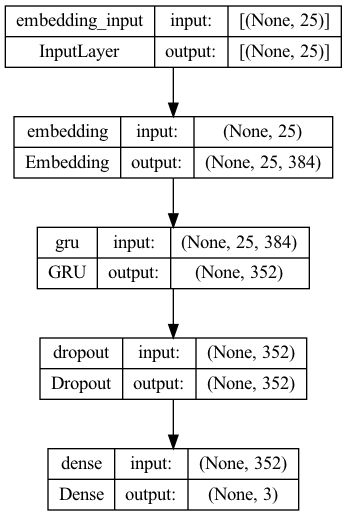

In [35]:
tf.keras.utils.plot_model(best_model_1, to_file='../plots/model_plots/gru_model_1.png', show_shapes=True)

In [37]:
y_pred = best_model_1.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

  1/338 [..............................] - ETA: 1:23

2022-11-16 14:29:57.357449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 14:29:57.404803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 2s 6ms/step


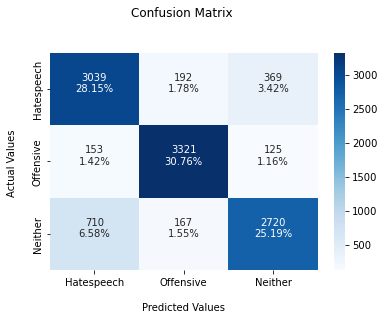

In [38]:
plotConfusionMatrix(cm)

In [39]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3600
           1       0.90      0.92      0.91      3599
           2       0.85      0.76      0.80      3597

    accuracy                           0.84     10796
   macro avg       0.84      0.84      0.84     10796
weighted avg       0.84      0.84      0.84     10796



In [40]:
best_model_1.save('../models/gru_model_1')

INFO:tensorflow:Assets written to: ../models/gru_model_1/assets


INFO:tensorflow:Assets written to: ../models/gru_model_1/assets


### Find best model for 20 epochs of training

In [16]:
tuner_2, best_model_2 = tuneModelByEpoch(20, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 2)

2023-01-15 21:02:12.135986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-15 21:02:12.136193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2023-01-15 21:02:12.576753: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-15 21:02:12.992115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-15 21:02:13.130638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-15 21:02:13.433659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-15 21:02:56.840511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-15 21:02:56.884031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-15 21:17:13.548847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

INFO:tensorflow:Oracle triggered exit


In [17]:
tuner_2.results_summary()

Results summary
Results in ../tuner_dir/gru_tuner_2/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 320
units: 320
dropout: False
lr: 0.00030187307077997794
rate: 0.4716395332419465
batch_size: 32
Score: 0.8386439681053162
Trial summary
Hyperparameters:
output_dim: 512
units: 480
dropout: True
lr: 0.0008978557461694481
rate: 0.45806413499202026
batch_size: 64
Score: 0.8163208365440369
Trial summary
Hyperparameters:
output_dim: 128
units: 448
dropout: True
lr: 0.004116823186183904
rate: 0.432162528829827
batch_size: 64
Score: 0.810022234916687
Trial summary
Hyperparameters:
output_dim: 480
units: 288
dropout: True
lr: 0.002606434463202174
rate: 0.1
batch_size: 32
Score: 0.7955724596977234
Trial summary
Hyperparameters:
output_dim: 288
units: 128
dropout: True
lr: 0.003902533338680906
rate: 0.3203104353460332
batch_size: 32
Score: 0.7864949703216553


In [18]:
best_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 320)           9225280   
                                                                 
 gru (GRU)                   (None, 320)               616320    
                                                                 
 dense (Dense)               (None, 3)                 963       
                                                                 
Total params: 9,842,563
Trainable params: 9,842,563
Non-trainable params: 0
_________________________________________________________________


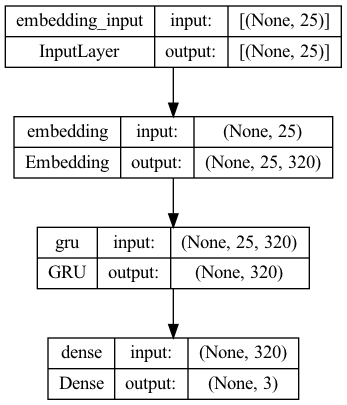

In [19]:
tf.keras.utils.plot_model(best_model_2, to_file='../plots/model_plots/gru_model_2.png', show_shapes=True)

In [20]:
y_pred = best_model_2.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

2023-01-16 00:28:32.947545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-16 00:28:33.153877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 3s 7ms/step


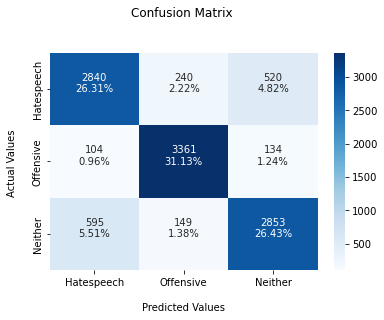

In [21]:
plotConfusionMatrix(cm)

In [22]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3600
           1       0.90      0.93      0.91      3599
           2       0.81      0.79      0.80      3597

    accuracy                           0.84     10796
   macro avg       0.84      0.84      0.84     10796
weighted avg       0.84      0.84      0.84     10796



In [23]:
best_model_2.save('../models/gru_model_2')

INFO:tensorflow:Assets written to: ../models/gru_model_2/assets


INFO:tensorflow:Assets written to: ../models/gru_model_2/assets


### Find best model for 30 epochs of training

In [10]:
tuner_3, best_model_3 = tuneModelByEpoch(30, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 3)

2022-11-16 22:07:34.034761: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 22:07:34.034992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-11-16 22:07:34.433653: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-16 22:07:34.831349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:07:34.961812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:07:35.127728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:07:59.865038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:07:59.909903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:19:53.000600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

INFO:tensorflow:Oracle triggered exit


In [12]:
tuner_3.results_summary()

Results summary
Results in ../tuner_dir/gru_tuner_3/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 288
units: 192
dropout: False
lr: 0.0002752082154413142
rate: 0.33490903343503753
batch_size: 32
Score: 0.8404964804649353
Trial summary
Hyperparameters:
output_dim: 192
units: 384
dropout: True
lr: 0.0011807478699245395
rate: 0.4796848596761888
batch_size: 128
Score: 0.8366061449050903
Trial summary
Hyperparameters:
output_dim: 480
units: 384
dropout: True
lr: 0.0001338028856513705
rate: 0.3906964236413446
batch_size: 128
Score: 0.8338273167610168
Trial summary
Hyperparameters:
output_dim: 64
units: 352
dropout: False
lr: 0.0031256760850773423
rate: 0.1854028074657743
batch_size: 128
Score: 0.8246572613716125
Trial summary
Hyperparameters:
output_dim: 96
units: 352
dropout: True
lr: 0.008031869449390674
rate: 0.1
batch_size: 32
Score: 0.8008521795272827


In [13]:
best_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 288)           8302752   
                                                                 
 gru (GRU)                   (None, 192)               277632    
                                                                 
 dense (Dense)               (None, 3)                 579       
                                                                 
Total params: 8,580,963
Trainable params: 8,580,963
Non-trainable params: 0
_________________________________________________________________


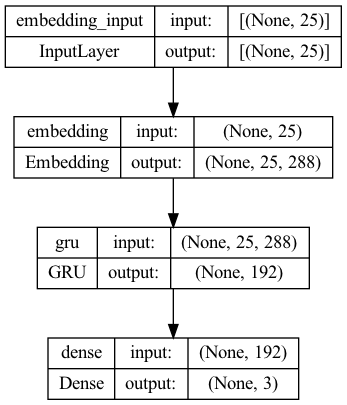

In [14]:
tf.keras.utils.plot_model(best_model_3, to_file='../plots/model_plots/gru_model_3.png', show_shapes=True)

In [15]:
y_pred = best_model_3.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

 10/338 [..............................] - ETA: 2s  

2022-11-16 23:07:27.283606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 23:07:27.324784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 2s 5ms/step


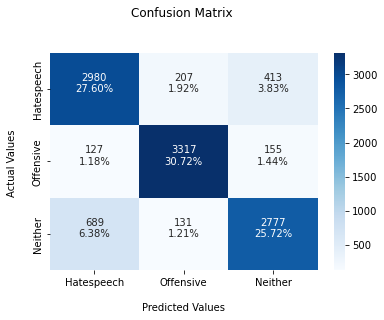

In [16]:
plotConfusionMatrix(cm)

In [17]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3600
           1       0.91      0.92      0.91      3599
           2       0.83      0.77      0.80      3597

    accuracy                           0.84     10796
   macro avg       0.84      0.84      0.84     10796
weighted avg       0.84      0.84      0.84     10796



In [18]:
best_model_3.save('../models/gru_model_3')

INFO:tensorflow:Assets written to: ../models/gru_model_3/assets


INFO:tensorflow:Assets written to: ../models/gru_model_3/assets
